# Analyze met data at each site
- partition precip
- Select a single year to model

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

# Original Swamp Angel observations
dirDataRaw = dirPre + 'GroundObs/SenatorBeck/Raw'

## Open data

In [3]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SNQ = xr.open_dataset('SNQ.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

In [4]:
# --------------------------------------------------------------------------------------------
# Add bulk stability measure to each site
RiBulk,_,_ = turbpy.bulkRichardson(SWA.Tair + 273.15, SWA.Tsrf + 273.15, SWA.WIND, 6 - SWA.snowDepth)
SWA['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(SNQ.Tair + 273.15, SNQ.Tsrf + 273.15, SNQ.WIND, 6 - SNQ.snowDepth)
SNQ['RiBulk'] = RiBulk
RiBulk,_,_ = turbpy.bulkRichardson(CDP.Tair + 273.15, CDP.Tsrf + 273.15, CDP.WIND, 6 - CDP.snowDepth)
CDP['RiBulk'] = RiBulk

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: divide by zero encountered in true_divide
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in multiply
  if not reflexive


In [6]:
# --------------------------------------------------------------------------------------------
# Resample to daily
dailyResample = False
if dailyResample:
    # Other accounting
    SWA_daily = SWA.resample(how='mean', freq='d', dim='time')
    SNQ_daily = SNQ.resample(how='mean', freq='d', dim='time')
    CDP_daily = CDP.resample(how='mean', freq='d', dim='time')

    os.chdir(dirData)
    SWA_daily.to_netcdf('SWA.ModTsfc.Daily.nc')
    SNQ_daily.to_netcdf('SNQ.ModTsfc.Daily.nc')
    CDP_daily.to_netcdf('CDP.ModTsfc.Daily.nc')

# Load daily resamples
else:
    SWA_daily = xr.open_dataset('SWA.ModTsfc.Daily.nc')
    SNQ_daily = xr.open_dataset('SNQ.ModTsfc.Daily.nc')
    CDP_daily = xr.open_dataset('CDP.ModTsfc.Daily.nc')

# --------------------------------------------------------------------------------------------
# Dictionaries for iterating
met = {'SWA': SWA,
       'SNQ': SNQ,
       'CDP': CDP}

metDaily = {'SWA_daily': SWA_daily,
            'SNQ_daily': SNQ_daily,
            'CDP_daily': CDP_daily}

## Functions

In [10]:
# --------------------------------------------------------------------------------------------
# Groupby water year
def water_year(time_index, last_month=9):
    '''
    Example usage:
    wy = SNOTEL.groupby(water_year(SNOTEL.t))
    Returns a groupby object of wy. Allows iteration by water year. A little clunky to use still...
    '''
    year = time_index.to_index().year
    year[time_index.to_index().month > last_month] += 1 
    return xr.DataArray(year, dims=time_index.dims, coords=time_index.coords, name='water_year')

## CDP solid precip

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1130: RuntimeWarning: invalid value encountered in less
  if not reflexive


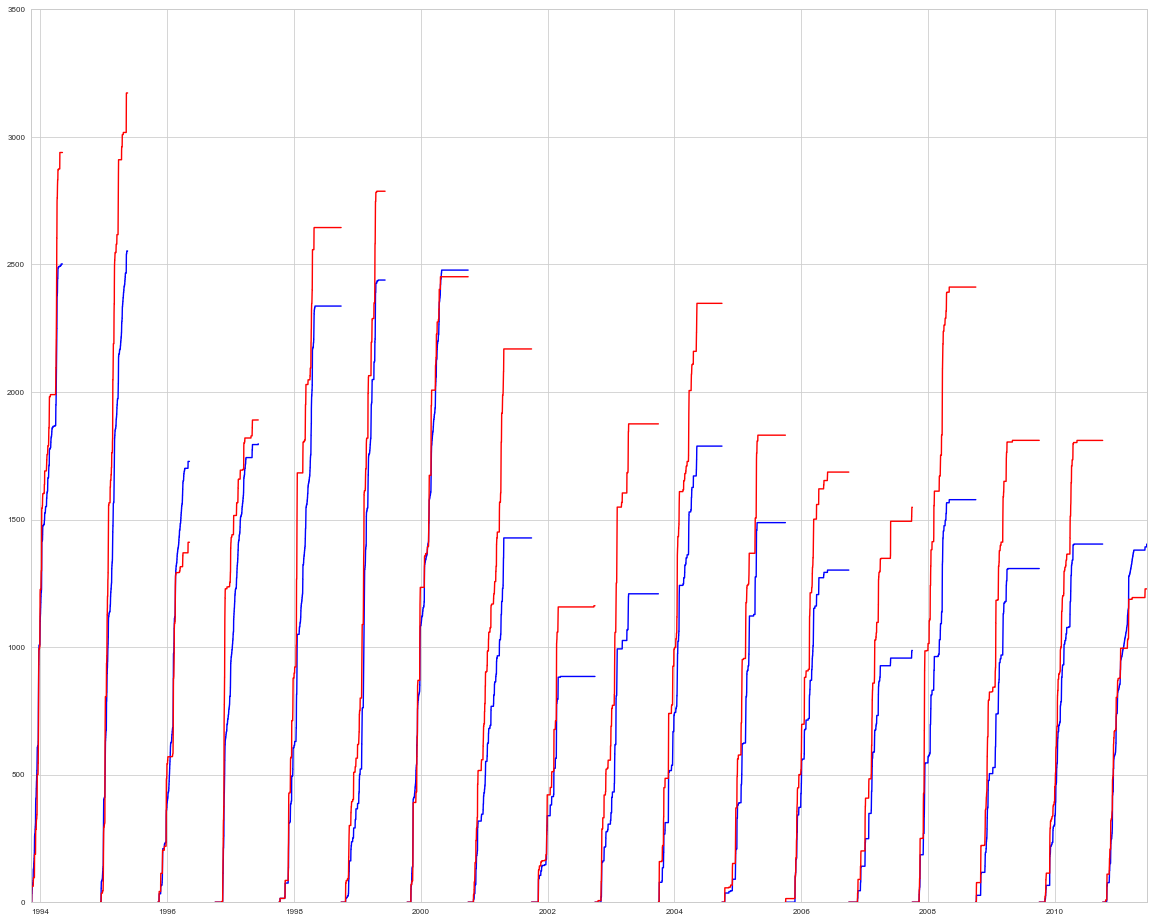

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
wy = CDP.groupby(water_year(CDP.time))

for wYear, wYearCDP in wy:
    posSnowDepth = wYearCDP.snowDepth.diff(dim='time')
    posSnowDepth[posSnowDepth < 0] = 0
    ax.plot(posSnowDepth.time, posSnowDepth.cumsum(dim='time') * 300, 'b')
    ax.plot(wYearCDP.time, wYearCDP.precipSnow.cumsum(dim='time') * 3600 * 10/3, 'r')

Units should now match between fields. Not so sure about the frozen precip 10/3rds multiplier (should transorm to kg of snow assuming a density of 300kg/m3). Clearly, the estimated acumulated frozen precip does not match though. I'm going to attrbute this to assuming a constant density.

- let's just assume that the solid precip is a reasonable observation and use Mark's wy 2006.

In [40]:
CDP

<xarray.Dataset>
Dimensions:     (time: 103995)
Coordinates:
  * time        (time) datetime64[ns] 1993-11-10 1993-11-10T01:00:00 ...
Data variables:
    Tair        (time) float64 0.66 0.11 0.13 -0.52 -0.38 -0.61 -0.67 -0.71 ...
    QS          (time) float64 0.004486 0.004266 0.004317 0.004117 0.004159 ...
    WIND        (time) float64 0.1 0.5 0.4 0.2 0.1 0.1 0.4 0.8 0.3 0.7 1.0 ...
    precipRain  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    precipSnow  (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    LWdwn       (time) float64 295.8 259.4 265.6 253.6 245.8 225.6 228.9 ...
    SWdwnDir    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 18.53 ...
    SWdwnDif    (time) float64 0.278 0.0 0.0 0.278 0.0 0.0 0.0 1.944 20.56 ...
    Press       (time) float64 8.726e+04 8.721e+04 8.719e+04 8.719e+04 ...
    SWdwn       (time) float64 0.278 0.0 0.0 0.278 0.0 0.0 0.0 1.944 20.56 ...
    precip      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0